# Welcome!
### - This notebook aims to give an end-to-end overview of tackling a real-life business problem all the way from data exploration & analysis to modelling & assessment. 
### - I also want to shed some light on the importance of interpretability of models and making them not only accurate, but at the end of the day understandable to your business clients.
### - We'll primarily focus on *Linear Regression* and the modelling concepts surrounding it, rather than preprocessing. LR is a really simple and interpretable modelling technique, which, along with the use of techniques like *Recursive Feature Elimination (RFE)* and *Variance Infalation Factor (VIF)*, can output models which show some good accuracy while also maintaining the ease to comprehend. 
### *Business Problem* : We are required to model the demand for shared bikes with the available independent variables. It will be used by the management to understand how exactly the demands vary with different features. They can accordingly manipulate the business strategy to meet the demand levels and meet the customer's expectations. Further, the model will be a good way for management to understand the demand dynamics of a new market. Dataset description can be found [here](https://www.kaggle.com/marklvl/bike-sharing-dataset).
### We'll follow the following 5 step-approach:
### 1. [Data Pre-Processsing](#dp)
### 2. [EDA](#eda)
### 3. [Modelling](#modelling)
### 4. [Residual Analysis](#ra)
### 5. [Prediction](#predict)



##### Starting off by importing libraries and setting things up....

In [118]:
# Filtering out the warnings

import warnings
warnings.filterwarnings('ignore')

In [119]:
# Importing the required libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 500)
# max columns displayed :500

In [120]:
# We will work on the 'day.csv' dataset for our demand prediction
bike = pd.read_csv('/kaggle/input/bike-sharing-dataset/day.csv')

# let's look at the data overiew 
print(bike.head())
print(bike.info())

   instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1        0        6           0   
1        2  2011-01-02       1   0     1        0        0           0   
2        3  2011-01-03       1   0     1        0        1           1   
3        4  2011-01-04       1   0     1        0        2           1   
4        5  2011-01-05       1   0     1        0        3           1   

   weathersit      temp     atemp       hum  windspeed  casual  registered  \
0           2  0.344167  0.363625  0.805833   0.160446     331         654   
1           2  0.363478  0.353739  0.696087   0.248539     131         670   
2           1  0.196364  0.189405  0.437273   0.248309     120        1229   
3           1  0.200000  0.212122  0.590435   0.160296     108        1454   
4           1  0.226957  0.229270  0.436957   0.186900      82        1518   

    cnt  
0   985  
1   801  
2  1349  
3  1562  
4  1600  
<class 'pandas.core.frame.

##### 731 instances and 15 features.

<a id='dp'></a>
## DATA PRE-PROCESSING

### Dropping columns:
- 'registered' and 'casual' add up to out target 'cnt', so are redundant, hence we drop them.
- 'dteday': The information in dteday is already captured in other features like weekday, holiday and season etc.
- 'instant': This is just the unique (index) record number, hence drop it. 
- 'atemp': 'atemp' & 'temp' are highly correlated, hence better to stick with pure 'temp' value as 'atemp' might be result of other factors such as humidity, windspeed etc. which are already under consideration as separate features.

In [121]:
bike.drop(columns=['registered','casual','instant','dteday','atemp'],axis=1,inplace=True)

### Renaming categories
##### For easily interpretable visulizations (done later)

#### Categorical Features:


##### Season:


In [122]:
def season_fun(x):
    if x==1:
        return 'Spring'
    elif x==2:
        return 'Summer'
    elif x==3:
        return 'Fall'
    else:
        return 'Winter'
   
bike['season']=bike.season.apply(season_fun)

##### Month:

In [123]:
bike['mnth'] = bike['mnth'].map({1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'})

##### Weather:

In [124]:
def weather_fun(x):
    if x==1:
        return 'Clear'
    elif x==2:
        return 'Mist'
    elif x==3:
        return 'LightRain'
    else:
        return 'HeavyRain'
   
bike['weathersit']=bike.weathersit.apply(weather_fun)

##### Weekday:

In [125]:
bike['weekday'] = bike['weekday'].map({0:'Sun',1:'Mon', 2:'Tues', 3:'wed', 4:'Thur',5:'Fri',6:'Sat'})

#### Binary Features:


##### 'Year', 'Working Day' & 'Holiday'

In [126]:
bike['yr'] = bike['yr'].map({0:'2018',1:'2019'})
bike['workingday'] = bike['workingday'].map({0:'No',1:'Yes'})
bike['holiday'] = bike['holiday'].map({0:'No',1:'Yes'})

<a id='eda'></a>

## EDA


### Missing value analysis:


In [127]:
bike.isnull().sum()

season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
hum           0
windspeed     0
cnt           0
dtype: int64

###### Great! We're dealing with NO missing values here.

### Let's do a quick pairplot between the numerical variables: 
- Temperature
- Humidity
- Windspeed

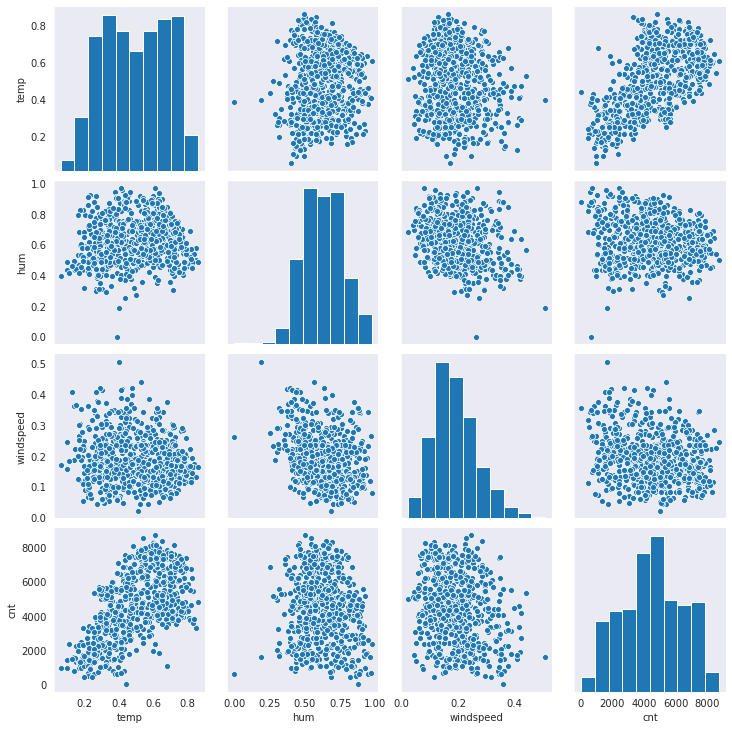

In [128]:
sns.set_style('dark')
sns.pairplot(bike[['temp','hum','windspeed','cnt']])


(array([0.5, 1.5, 2.5, 3.5]), <a list of 4 Text major ticklabel objects>)

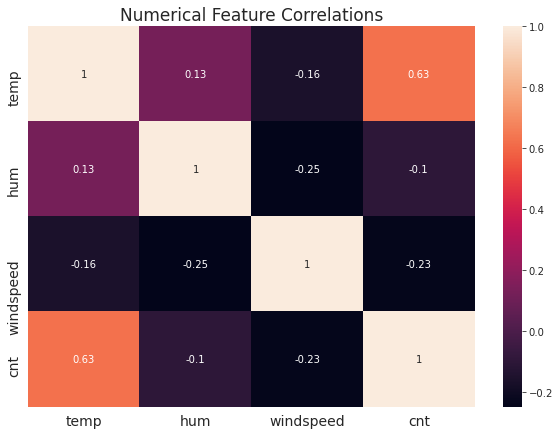

In [129]:
plt.figure(figsize=(10,7))
sns.set_style('white')
sns.heatmap(bike[['temp','hum','windspeed','cnt']].corr(), annot=True)
plt.title('Numerical Feature Correlations', fontsize=17)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#### Inference: 
- Visible +ve correlation b/w CNT and TEMP, which means people prefer to go out on warmer days.
- No linear correlation observed in other features.

### Let's see categorical bivariate relations with 'cnt'

#### Count v/s Year

(array([-2000.,     0.,  2000.,  4000.,  6000.,  8000., 10000.]),
 <a list of 7 Text major ticklabel objects>)

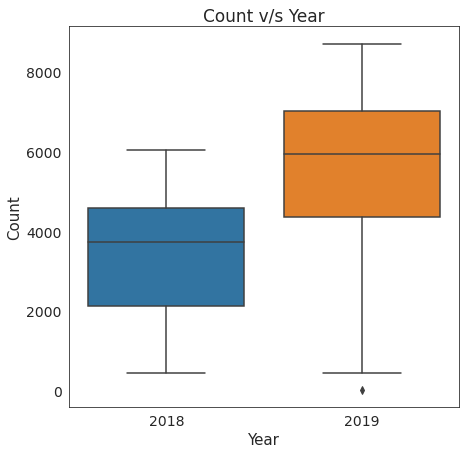

In [130]:
plt.figure(figsize=(7,7))
sns.set_style('white')
sns.boxplot(bike.yr,bike.cnt)
plt.title('Count v/s Year', fontsize=17)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#### Inference: 
- Visible increase of bike count year on year from 2018 to 2019, a much higher median indicates that the company is taking some right decisions to increase demand year on year.

#### Count v/s Weekdays

(array([-2000.,     0.,  2000.,  4000.,  6000.,  8000., 10000.]),
 <a list of 7 Text major ticklabel objects>)

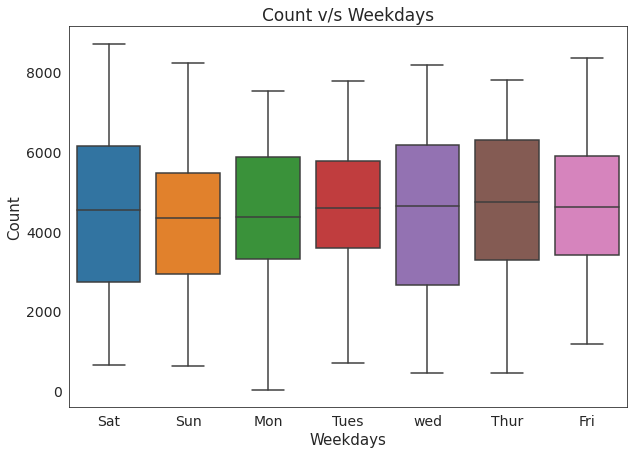

In [131]:
plt.figure(figsize=(10,7))
sns.set_style('white')
sns.boxplot(bike.weekday,bike.cnt)
plt.title('Count v/s Weekdays', fontsize=17)
plt.xlabel('Weekdays', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#### Inference: 
- No visible difference between weekdays as such.

#### Count v/s Holiday


(array([-2000.,     0.,  2000.,  4000.,  6000.,  8000., 10000.]),
 <a list of 7 Text major ticklabel objects>)

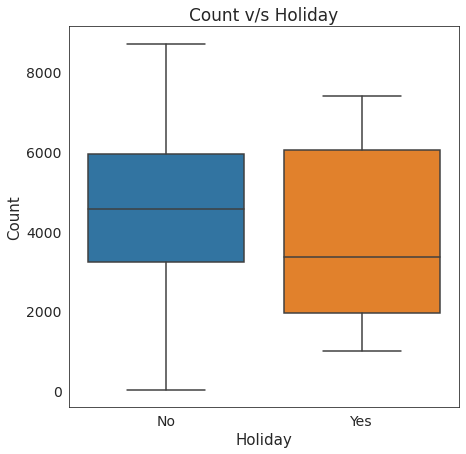

In [132]:
plt.figure(figsize=(7,7))
sns.set_style('white')
sns.boxplot(bike.holiday,bike.cnt)
plt.title('Count v/s Holiday', fontsize=17)
plt.xlabel('Holiday', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#### Inference: 
- Visible median decrease of bike demand on holidays as mostly bikes are rented for work travel, which decreases on holidays, hence, less bikes are rented.

#### Count v/s Workingday


(array([-2000.,     0.,  2000.,  4000.,  6000.,  8000., 10000.]),
 <a list of 7 Text major ticklabel objects>)

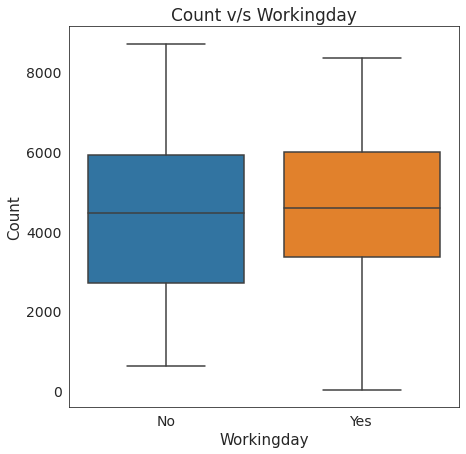

In [133]:
plt.figure(figsize=(7,7))
sns.set_style('white')
sns.boxplot(bike.workingday,bike.cnt)
plt.title('Count v/s Workingday', fontsize=17)
plt.xlabel('Workingday', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#### Inference: 
- Very slight increase in demand on working days which is also obvious as people rent bikes for work travel.

#### Count v/s Month

(array([-2000.,     0.,  2000.,  4000.,  6000.,  8000., 10000.]),
 <a list of 7 Text major ticklabel objects>)

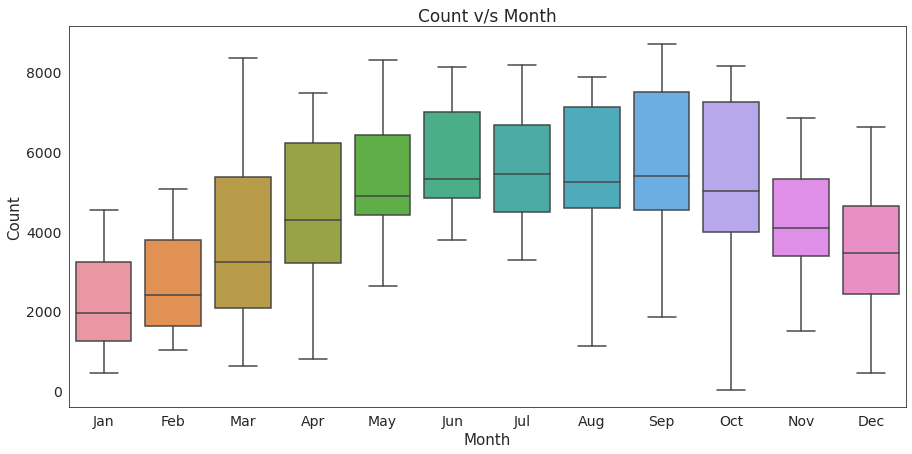

In [134]:
plt.figure(figsize=(15,7))
sns.set_style('white')
sns.boxplot(bike.mnth,bike.cnt)
plt.title('Count v/s Month', fontsize=17)
plt.xlabel('Month', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#### Inference: 
- A clear trend can be observed, demand increases right from being least in 'Jan' , peaking at around 'Jul-Sep', then following a decrease again till Jan.  

#### Count v/s Season


(array([-2000.,     0.,  2000.,  4000.,  6000.,  8000., 10000.]),
 <a list of 7 Text major ticklabel objects>)

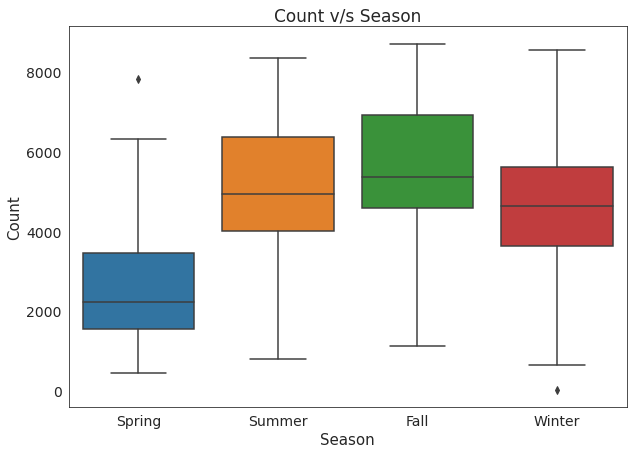

In [135]:
plt.figure(figsize=(10,7))
sns.set_style('white')
sns.boxplot(bike.season,bike.cnt)
plt.title('Count v/s Season', fontsize=17)
plt.xlabel('Season', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#### Inference: 
- Demand falls in Spring, and is the most in Fall then Summer.

#### Count v/s Weather

(array([-2000.,     0.,  2000.,  4000.,  6000.,  8000., 10000.]),
 <a list of 7 Text major ticklabel objects>)

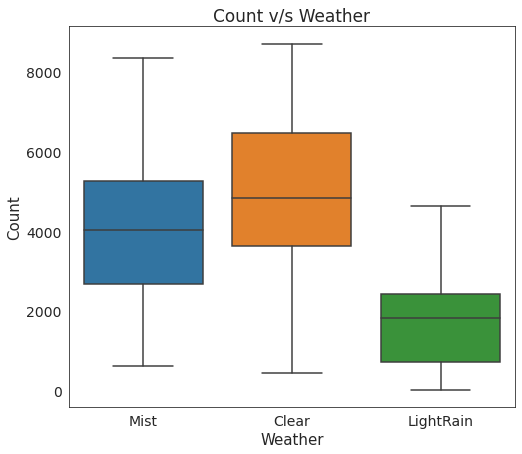

In [136]:
plt.figure(figsize=(8,7))
sns.set_style('white')
sns.boxplot(bike.weathersit,bike.cnt)
plt.title('Count v/s Weather', fontsize=17)
plt.xlabel('Weather', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#### Inference: 
- Demands drop severly in 'Rains' which is obvious as people don't wanna ride in rain and conversely, demands are most in Clear weather conditions.

<a id='modelling'></a>

## MODELLING

## Creating Dummies


##### Binary Features : Mapping back to 0-1

In [137]:
bike['yr'] = bike['yr'].map({'2018':0,'2019':1})
bike['workingday'] = bike['workingday'].map({'No':0,'Yes':1})
bike['holiday'] = bike['holiday'].map({'No':0,'Yes':1})

##### Categorical Features: One-Hot Encoding/Dummification

In [138]:
# Let's drop the first column from bike df using 'drop_first = True'
columns = ['season','mnth','weekday','weathersit']

for col in columns:
    dummies = pd.get_dummies(bike[col], drop_first = True)
    # Add the results to the original housing dataframe
    bike = pd.concat([bike, dummies], axis = 1)
    bike.drop(col, axis = 1, inplace = True)

In [139]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   yr          731 non-null    int64  
 1   holiday     731 non-null    int64  
 2   workingday  731 non-null    int64  
 3   temp        731 non-null    float64
 4   hum         731 non-null    float64
 5   windspeed   731 non-null    float64
 6   cnt         731 non-null    int64  
 7   Spring      731 non-null    uint8  
 8   Summer      731 non-null    uint8  
 9   Winter      731 non-null    uint8  
 10  Aug         731 non-null    uint8  
 11  Dec         731 non-null    uint8  
 12  Feb         731 non-null    uint8  
 13  Jan         731 non-null    uint8  
 14  Jul         731 non-null    uint8  
 15  Jun         731 non-null    uint8  
 16  Mar         731 non-null    uint8  
 17  May         731 non-null    uint8  
 18  Nov         731 non-null    uint8  
 19  Oct         731 non-null    u

##### All datatypes are proper, 27 independent, one dependent feature.

## Splitting the Data into Training and Testing Sets

- Going with a 70-30 split.

In [140]:
from sklearn.model_selection import train_test_split

# We specify this so that the train and test data set always have the same rows, respectively

df_train, df_test = train_test_split(bike, train_size = 0.7, test_size = 0.3, random_state = 100)

### Rescaling the Features 

- We will use Standard scaling.

##### NOTE: I had used MinMaxScaler before, but wasn't able to get more than 77% on test set, as MinMaxScaler doesn't perform well in presence of skewed distributions or in presence of outliers, hence using Z-Score or Standard Scaling as this is a much better scaling method in these conditions.

In [141]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables
num_vars = ['temp', 'hum', 'windspeed', 'cnt']

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

df_train.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,Spring,Summer,Winter,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Mon,Sat,Sun,Thur,Tues,wed,LightRain,Mist
576,1,0,1,1.323157,0.273072,-0.476234,1.331867,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
426,1,0,1,-0.748938,0.192137,-0.589635,-0.666888,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
729,1,0,0,-1.284116,-1.013193,2.089537,-1.381350,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
482,1,0,1,-0.177166,-1.585507,2.048917,0.886223,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
111,0,0,1,-0.840418,0.695080,0.381518,-1.439100,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


### Dividing into X and Y sets for the model building

- 'cnt': Count of Bikes is our target variable.

In [142]:
y_train = df_train.pop('cnt')
X_train = df_train

## Building our model

Approach:
1. Use RFE for Coarse-tuning.
2. Fine-tune by following an iterative approach:
- Build model with all features post-RFE
- Check for p-values of features (significance at 2%)
- Note down our evaluation metric scores - r2 and adjusted r2
- Check for VIF (>5 is bad)
- Drop features based on VIF and p-value and repeat this process.

NOTE: Do not drop a feature if there is a considerable decrease in r2_scores, it means that it is an important feature, rollback to the previous model and remodell by dropping another feature.

We will be using the **LinearRegression function from SciKit Learn** for its compatibility with RFE (which is a utility from sklearn)

### RFE
- Recursive feature elimination: Used for narrowing down on the number of variables base on various metrics and significance, basically gives the top N features.
- Reducing predictiors from 27 to 15 using RFE and then proceeding with manual elimination using p-value and VIF. 

In [143]:
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [144]:
# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 15)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [145]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', False, 6),
 ('temp', True, 1),
 ('hum', False, 4),
 ('windspeed', False, 2),
 ('Spring', True, 1),
 ('Summer', False, 7),
 ('Winter', True, 1),
 ('Aug', False, 12),
 ('Dec', True, 1),
 ('Feb', True, 1),
 ('Jan', True, 1),
 ('Jul', True, 1),
 ('Jun', False, 11),
 ('Mar', False, 10),
 ('May', False, 3),
 ('Nov', True, 1),
 ('Oct', False, 8),
 ('Sep', True, 1),
 ('Mon', True, 1),
 ('Sat', False, 5),
 ('Sun', True, 1),
 ('Thur', False, 14),
 ('Tues', False, 9),
 ('wed', False, 13),
 ('LightRain', True, 1),
 ('Mist', True, 1)]

##### Selected features TOP 15 after RFE

In [146]:
col = X_train.columns[rfe.support_]
col

Index(['yr', 'holiday', 'temp', 'Spring', 'Winter', 'Dec', 'Feb', 'Jan', 'Jul',
       'Nov', 'Sep', 'Mon', 'Sun', 'LightRain', 'Mist'],
      dtype='object')

##### Dropped features

In [147]:
X_train.columns[~rfe.support_]

Index(['workingday', 'hum', 'windspeed', 'Summer', 'Aug', 'Jun', 'Mar', 'May',
       'Oct', 'Sat', 'Thur', 'Tues', 'wed'],
      dtype='object')

### Building model using statsmodel, for the detailed statistics


In [148]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [149]:
# Adding a constant variable 
import statsmodels.api as sm  
X_train_rfe = sm.add_constant(X_train_rfe)

In [150]:
lm = sm.OLS(y_train,X_train_rfe).fit()   # Running the linear model

In [151]:
#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     168.1
Date:                Wed, 23 Sep 2020   Prob (F-statistic):          3.61e-183
Time:                        05:25:46   Log-Likelihood:                -263.30
No. Observations:                 511   AIC:                             558.6
Df Residuals:                     495   BIC:                             626.4
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2135      0.044     -4.905      0.0

##### 'Mon' is insignificant (Significance at 2%), checking VIF.... 


#### VIF: Variance Inflation Factor
- Used to check if any multicollinearity exists between the predictor variables.
- A model is created with each variable kept as target and others as predictors and it is observed whether a particular variable's value can be predicted using the other independent variables.
- Higher the value of VIF, more the collinearity.

In [152]:
# Calculate the VIFs for the model

# dropping const as const isn't a variable
vif_df = X_train_rfe.drop(['const'], axis=1)

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = vif_df
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,Spring,3.73
2,temp,2.79
4,Winter,2.61
7,Jan,2.38
6,Feb,1.96
9,Nov,1.85
0,yr,1.74
5,Dec,1.63
8,Jul,1.41
14,Mist,1.39


##### No multicollinearity as such, Dropping 'Mon' on basis of low significance.


In [153]:
X_train_new = X_train_rfe.drop(['Mon'], axis=1)

In [154]:
# fitting a model again
lm = sm.OLS(y_train,X_train_new).fit()   # Running the linear model

print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     179.1
Date:                Wed, 23 Sep 2020   Prob (F-statistic):          1.31e-183
Time:                        05:25:46   Log-Likelihood:                -264.96
No. Observations:                 511   AIC:                             559.9
Df Residuals:                     496   BIC:                             623.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2286      0.043     -5.339      0.0

##### Hardly any decrease in r2_score and adjusted r2_score. Now, 'Feb' is insignificant (significance at 2%), let's see the VIF.

In [155]:
# Calculate the VIFs for the model

# dropping const
vif_df = X_train_new.drop(['const'], axis=1)

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = vif_df
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,Spring,3.72
2,temp,2.78
4,Winter,2.58
7,Jan,2.37
6,Feb,1.96
9,Nov,1.84
0,yr,1.72
5,Dec,1.63
8,Jul,1.41
13,Mist,1.38


##### No multicollinearity as such, Dropping 'Feb' on basis of low significance.


In [156]:
X_train_new = X_train_new.drop(['Feb'], axis=1)
# fitting a model again, without holiday, atemp
lm = sm.OLS(y_train,X_train_new).fit()   # Running the linear model

print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     191.2
Date:                Wed, 23 Sep 2020   Prob (F-statistic):          8.05e-184
Time:                        05:25:46   Log-Likelihood:                -267.20
No. Observations:                 511   AIC:                             562.4
Df Residuals:                     497   BIC:                             621.7
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2360      0.043     -5.514      0.0

##### Minimal change in r2 scores. Almost all features are significant, may drop 'Jan' for least significance, let's test the multicollinearity

In [157]:
# Calculate the VIFs for the model

# dropping const
vif_df = X_train_new.drop(['const'], axis=1)

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = vif_df
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,temp,2.68
3,Spring,2.58
4,Winter,2.56
8,Nov,1.82
6,Jan,1.72
0,yr,1.71
5,Dec,1.51
7,Jul,1.40
12,Mist,1.38
9,Sep,1.17


##### No multicollinearity as such, Dropping 'Jan' on basis of low significance.

In [158]:
X_train_new = X_train_new.drop(['Jan'], axis=1)
# fitting a model again, without holiday, atemp
lm = sm.OLS(y_train,X_train_new).fit()   # Running the linear model

print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     205.2
Date:                Wed, 23 Sep 2020   Prob (F-statistic):          5.81e-184
Time:                        05:25:46   Log-Likelihood:                -269.63
No. Observations:                 511   AIC:                             565.3
Df Residuals:                     498   BIC:                             620.3
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2451      0.043     -5.732      0.0

##### Minimal change in r2 scores. All features are significant, may drop 'Dec' for least significance, let's test the multicollinearity

In [159]:
# Calculate the VIFs for the model

# dropping const
vif_df = X_train_new.drop(['const'], axis=1)

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = vif_df
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,Winter,2.56
2,temp,2.51
3,Spring,2.26
7,Nov,1.80
0,yr,1.70
5,Dec,1.45
6,Jul,1.38
11,Mist,1.37
8,Sep,1.17
9,Sun,1.16


##### No multicollinearity as such, Dropping 'Dec' on basis of least relative significance.

In [160]:
X_train_new = X_train_new.drop(['Dec'], axis=1)
# fitting a model again, without holiday, atemp
lm = sm.OLS(y_train,X_train_new).fit()   # Running the linear model

print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     221.1
Date:                Wed, 23 Sep 2020   Prob (F-statistic):          7.56e-184
Time:                        05:25:46   Log-Likelihood:                -272.71
No. Observations:                 511   AIC:                             569.4
Df Residuals:                     499   BIC:                             620.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2586      0.043     -6.069      0.0

##### Minimal change in r2_scores. Almost all features are significant, may drop 'Nov' for least significance, let's test the multicollinearity

In [161]:
# Calculate the VIFs for the model

# dropping const
vif_df = X_train_new.drop(['const'], axis=1)

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = vif_df
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,temp,2.45
3,Spring,2.26
4,Winter,2.06
0,yr,1.70
6,Nov,1.58
5,Jul,1.37
10,Mist,1.37
7,Sep,1.17
8,Sun,1.16
1,holiday,1.05


##### No multicollinearity as such, Dropping 'Nov' on basis of least relative significance.

In [162]:
X_train_new = X_train_new.drop(['Nov'], axis=1)
# fitting a model again, without holiday, atemp
lm = sm.OLS(y_train,X_train_new).fit()   # Running the linear model

print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     241.2
Date:                Wed, 23 Sep 2020   Prob (F-statistic):          3.84e-184
Time:                        05:25:47   Log-Likelihood:                -274.86
No. Observations:                 511   AIC:                             571.7
Df Residuals:                     500   BIC:                             618.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2670      0.043     -6.273      0.0

##### All features are significant, let's test the multicollinearity

In [163]:
# Calculate the VIFs for the model

# dropping const
vif_df = X_train_new.drop(['const'], axis=1)

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = vif_df
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,temp,2.42
3,Spring,2.25
0,yr,1.70
4,Winter,1.57
5,Jul,1.37
9,Mist,1.37
6,Sep,1.16
7,Sun,1.16
8,LightRain,1.05
1,holiday,1.04


##### All features pass VIF

##### NOTE: I tried to fit a model after removing 'temp' or 'Spring' for slightly above average VIF but it lead to significant r2_score drops, this means 'temp' & 'spring' are important features and should not be dropped.

## This is our FINAL model with 10 features:

| Feature | Coefficient | Inference | 
| :- | :- | :- |
| Year |  1.054 | +ve coef indicates as year increases, bike demand increases, basically Demand(2019) > Demand(2018). Hence there's a Year on Year increase in demand. | 
| Spring | -0.544 | -ve coef indicates demand falls in Spring, which is consistant with the EDA results too. |
| Holiday |  -0.375 | -ve coef means demand decreases on holidays, again consistant with EDA. |   
| Temperature |  0.456 | +ve coef means people prefer warmer days, consistant with EDA. | 
| Winter |  0.259 |  +ve coef indicates demand increases in Winter, consistant with the EDA. |  
| Mist | -0.353 | -ve coef, people avoid misty days, demand falls, consistant with EDA. |
| LightRain | -1.372 | -ve coef, people avoid rainy days even more (higher magnitude of negativity), demand falls, consistant with EDA. |
| Sunday | -0.184 | -ve coef, the model suggests people don't ride on Sundays, again makes sense. |
| September | 0.249 | +ve coef, demand increases in September, consistant with EDA. |
| July | -0.293 | -ve coef, demand decreases in July, this is an interesting finding which our EDA coudn't capture. |

            - R2:       0.828
            - Adj.R2:   0.825 
            


<a id='ra'></a>

## Residual Analysis of the train data

- Checking for LR assumptions


### Distribution of Residuals


- Checking if the error terms are normally distributed (which is infact, one of the major assumptions of linear regression), let us plot the histogram of the error terms and see what it looks like.

In [164]:
y_train_price = lm.predict(X_train_new)

In [165]:
# Importing the required libraries for plots.
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Text(0.5, 0, 'Errors')

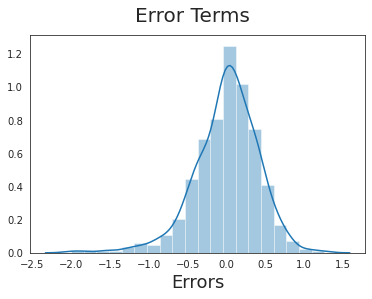

In [166]:
# Plot the histogram of the error terms
residuals = (y_train - y_train_price)

fig = plt.figure()
sns.distplot(residuals, bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

#####  Normally distributed residuals.


### Dependence of residuals on X & y (Absence of Autocorrelation)

- Another assumption of LR is that the residuals should not be dependent on X or y.
- The DW-statistic, which is used for calculating autocorrelation, is 2.010 for our final model. Which automatically indicates that out model is free of autocorrelation as the ideal value is 2.000, still, visualizing this...

##### Errors v/s y


Text(0, 0.5, 'Y')

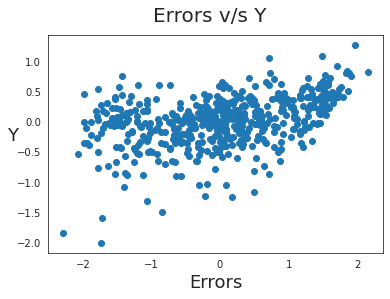

In [167]:
fig = plt.figure()
plt.scatter(y_train,residuals)
fig.suptitle('Errors v/s Y', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18) 
plt.ylabel('Y', fontsize = 18, rotation = 0) 

##### No dependence observed.

##### Errors v/s X

- Only one numrical variable in final model : 'temp'

Text(0, 0.5, 'X (temp)')

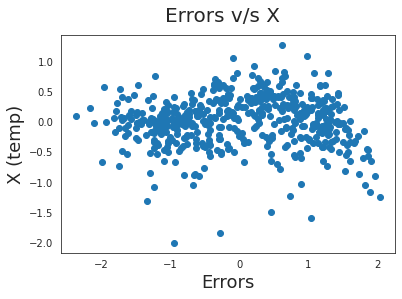

In [168]:
fig = plt.figure()
plt.scatter(X_train[['temp']],(y_train - y_train_price))
fig.suptitle('Errors v/s X', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)   
plt.ylabel('X (temp)', fontsize = 18)   

##### No dependence observed.

#### Now that we have all our assumptions of LR taken care of in our final model:
    - Linear Model
    - VIF - No features are multicollinear.
    - Autocorrelation - No correlation between residuals and X or y.
    - Normally distributed residuals.
    
#### We can go ahead and use this model for predictions.

<a id='predict'></a>

## Making Predictions

##### Appying the same transformations as training set...

In [169]:
num_vars = ['temp', 'hum', 'windspeed', 'cnt']

df_test[num_vars] = scaler.transform(df_test[num_vars])

In [170]:
y_test = df_test.pop('cnt')
X_test = df_test

In [171]:
# Now let's use our model to make predictions.

# Creating X_test_new dataframe by dropping variables from X_test
X_train_new = X_train_new.drop(['const'], axis=1)

X_test_new = X_test[X_train_new.columns]

# Adding a constant variable 
X_test_new = sm.add_constant(X_test_new)

In [172]:
# Making predictions
y_pred = lm.predict(X_test_new)

Text(0, 0.5, 'y_pred')

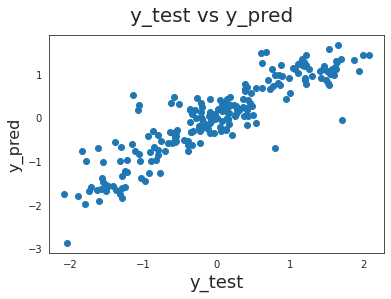

In [173]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label

##### Highly similar values 

In [174]:
from sklearn.metrics import r2_score

print(f'R2 Score on Test set is {round(r2_score(y_test, y_pred)*100,3)} %')

n = 731
p = 10
r2 = 0.80935

adjusted_r2_test = 1-((1-r2)*(n-1)/(n-p-1))

print(f'Adjusted R2 Score on Test set is {round(adjusted_r2_test*100,3)} %')

# n = number of sample size , p = number of independent variables

R2 Score on Test set is 80.935 %
Adjusted R2 Score on Test set is 80.67 %


### Finally, our 10-feature model was able to obtain:

#### Training Scores:
                - R2 Score:            82.8%
                - Adjusted R2 Score:   82.5%
***

#### Test Scores:
                - R2 Score:            80.9%
                - Adjusted R2 Score:   80.7%
                
------------------------------------------------------------------------
                                                                Thank you!       

------------------------------------------------------------------------